In [18]:
import pandas as pd
import numpy as np

import zipfile

from statsmodels.stats.proportion import proportions_ztest

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Table of contents

[1. Предобработка данных](https://colab.research.google.com/drive/1RsLY9HJOOMPI7rd6wvXB-trOk4Hm4OIm?authuser=1#scrollTo=oPIGkQK2JmzW&line=1&uniqifier=1)

[2. Анализ данных](https://colab.research.google.com/drive/1RsLY9HJOOMPI7rd6wvXB-trOk4Hm4OIm?authuser=1#scrollTo=VejD32UFbT7O&line=1&uniqifier=1)

[3. A/B тестирование](https://colab.research.google.com/drive/1RsLY9HJOOMPI7rd6wvXB-trOk4Hm4OIm?authuser=1#scrollTo=hiy5QdS8gdGq&line=1&uniqifier=1)

**Задача:**

На главной странице магазина пользователям показывают баннеры, чтобы стимулировать их продажи. Теперь там случайным образом отображается один из 5 баннеров. Каждый баннер рекламирует определенный товар. Наши маркетологи считают, что опыт работы с баннерами может варьироваться в зависимости от сегмента, а их эффективность может зависеть от особенностей поведения пользователей.


Источник данных: https://www.kaggle.com/datasets/podsyp/how-to-do-product-analytics

In [2]:
zip_path = '/content/drive/MyDrive/analytics/ab_test_proj/archive.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('/content')

data = pd.read_csv('product.csv')

In [3]:
data.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


Колонки:
1. **order_id** -- уникальный номер покупки;
2. **user_id** -- уникальный идентификатор пользователя;
3. **page_id** -- уникальный номер страницы;
4. **product** -- рекламный баннер продукта / покупка;
5. **site_version** -- версия сайта (мобильная или десктопная);
6. **time** -- время действия;
7. **title** -- тип события (показ, клик или покупка);
8. **target** -- целевое событие (покупка).

## Предобработка данных

**1. Проверим наличие пропущенных значений:**

In [4]:
data.isnull().sum()

order_id        0
user_id         0
page_id         0
product         0
site_version    0
time            0
title           0
target          0
dtype: int64

**2. Посмотрим на типы данных и преобразуем некоторые колонки при необходимости:**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471220 entries, 0 to 8471219
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   order_id      object
 1   user_id       object
 2   page_id       object
 3   product       object
 4   site_version  object
 5   time          object
 6   title         object
 7   target        int64 
dtypes: int64(1), object(7)
memory usage: 517.0+ MB


Преобразуем колонку 'time' в формат 'datetime':

In [6]:
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')

Отдельно извлечем колонку с датами:

In [7]:
data['date'] = data['time'].dt.date

**3. Проверим наличие дубликатов**

In [8]:
duplicates = data.duplicated()

In [9]:
sum(duplicates)

0

**4. Удалим ненужные данные:**

In [10]:
data = data.drop('page_id', axis=1)

In [11]:
data.head()

,order_id,user_id,product,site_version,time,title,target,date
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,sneakers,desktop,2019-01-11 09:24:43,banner_click,0,2019-01-11
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,sneakers,desktop,2019-01-09 09:38:51,banner_show,0,2019-01-09
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0,2019-01-09
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,2019-01-03 08:58:18,banner_show,0,2019-01-03
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,2019-01-03 08:59:15,banner_click,0,2019-01-03


**5. Сохраним данные**

In [12]:
data.to_csv('product_data.csv', index=False)

## Анализ данных

Анализ данных предсавлен на дэшборде, составленном в Power BI [(ссылка на проект)](https://github.com/acumfly/data-analysis/tree/main/Power%20BI%20Dashboards/Анализ%20эффективности%20баннеров%20интернет-магазина%20спортивных%20товаров)

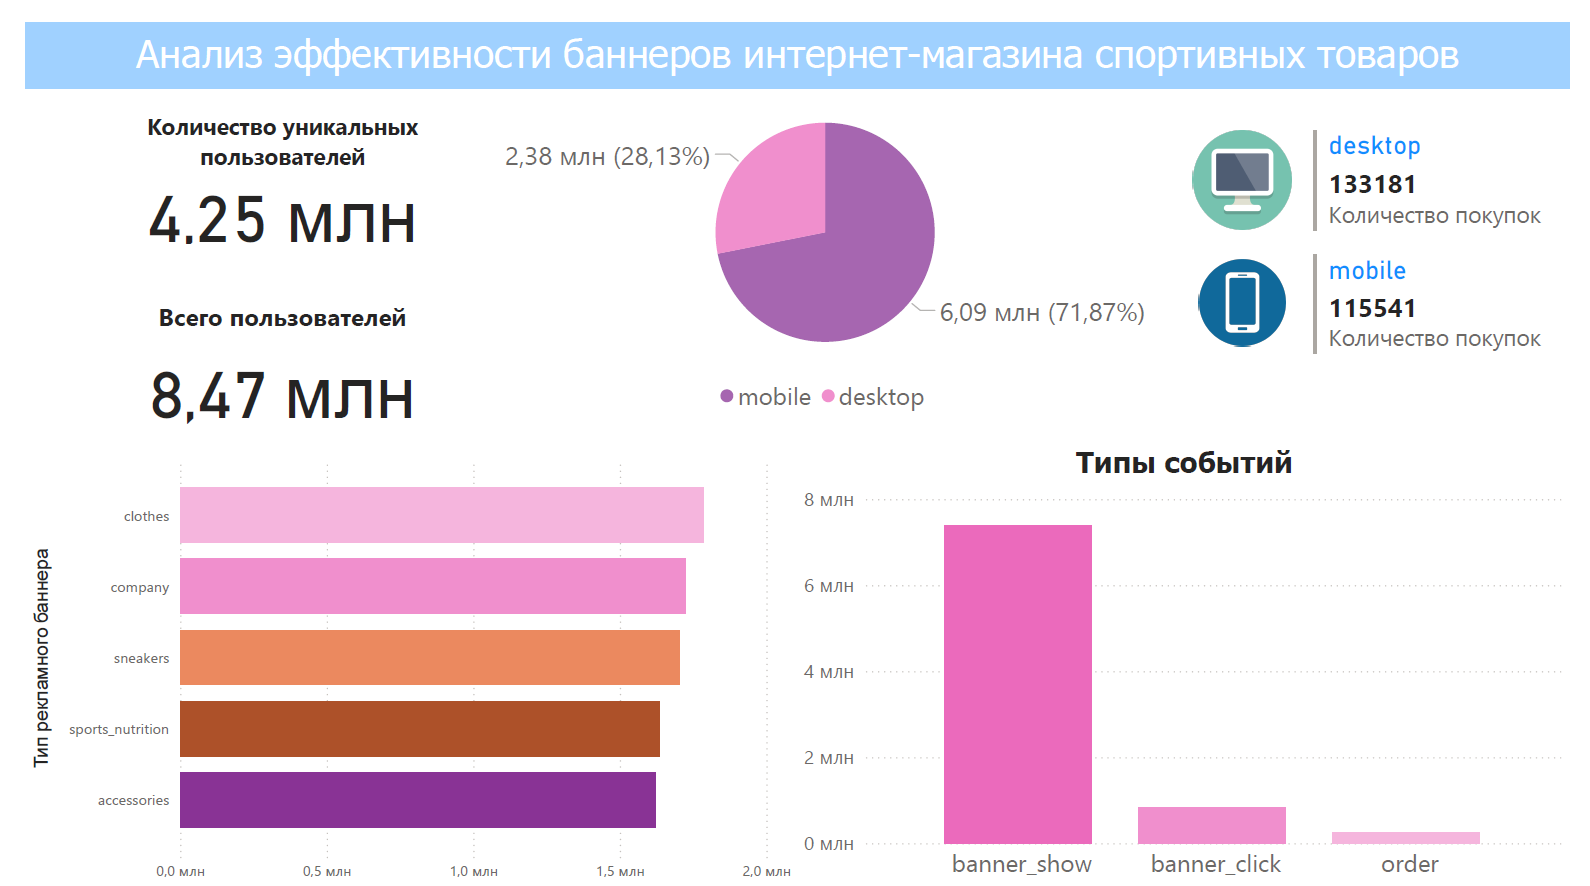

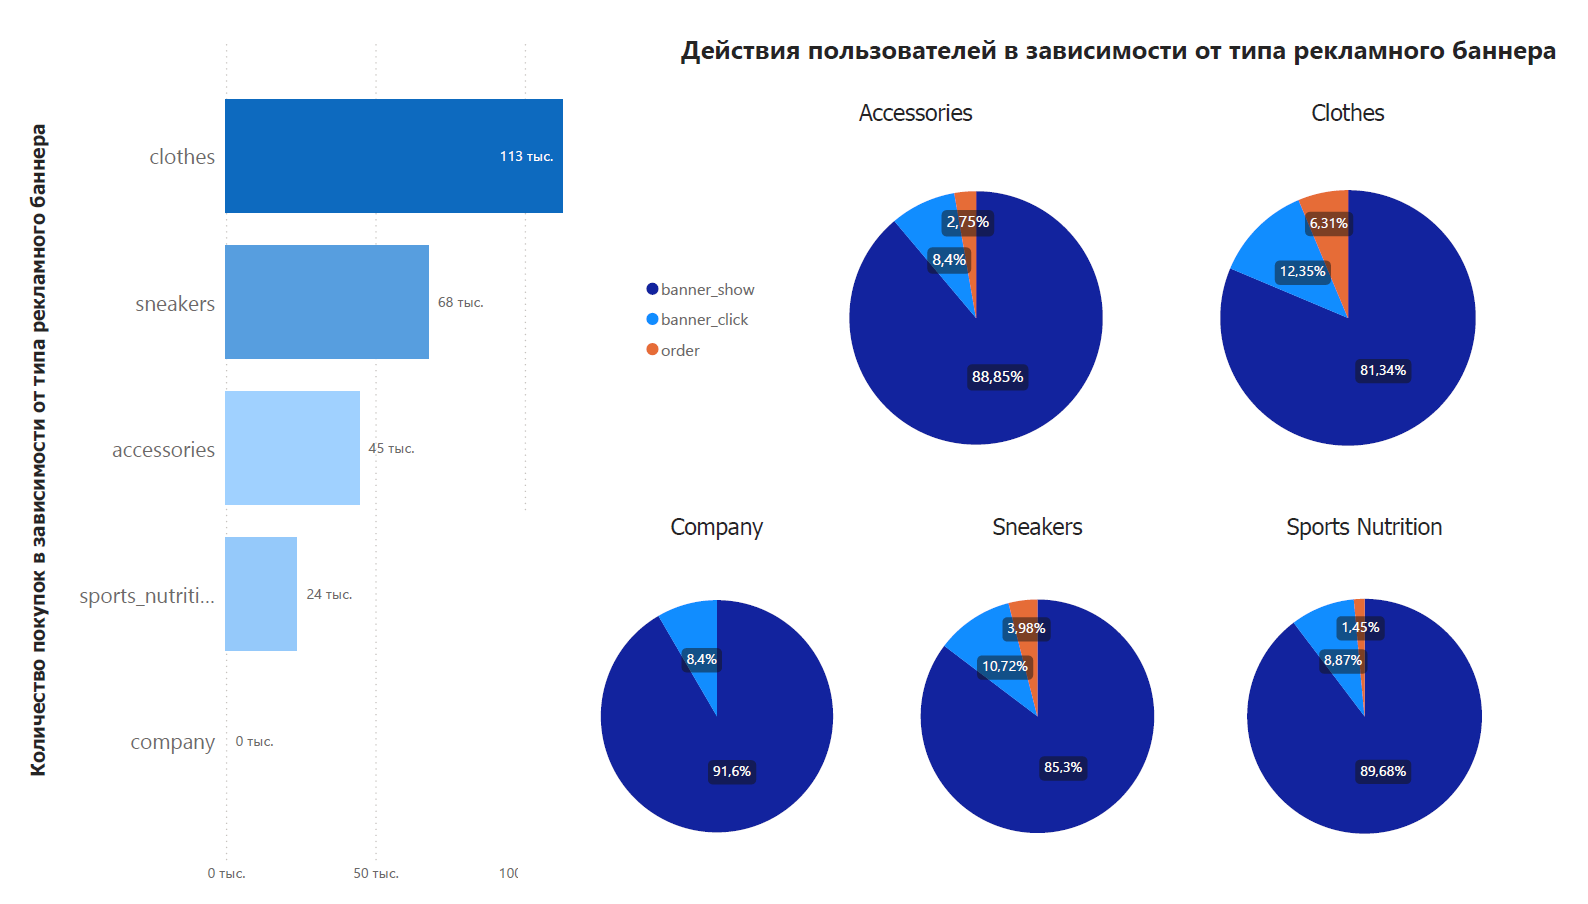

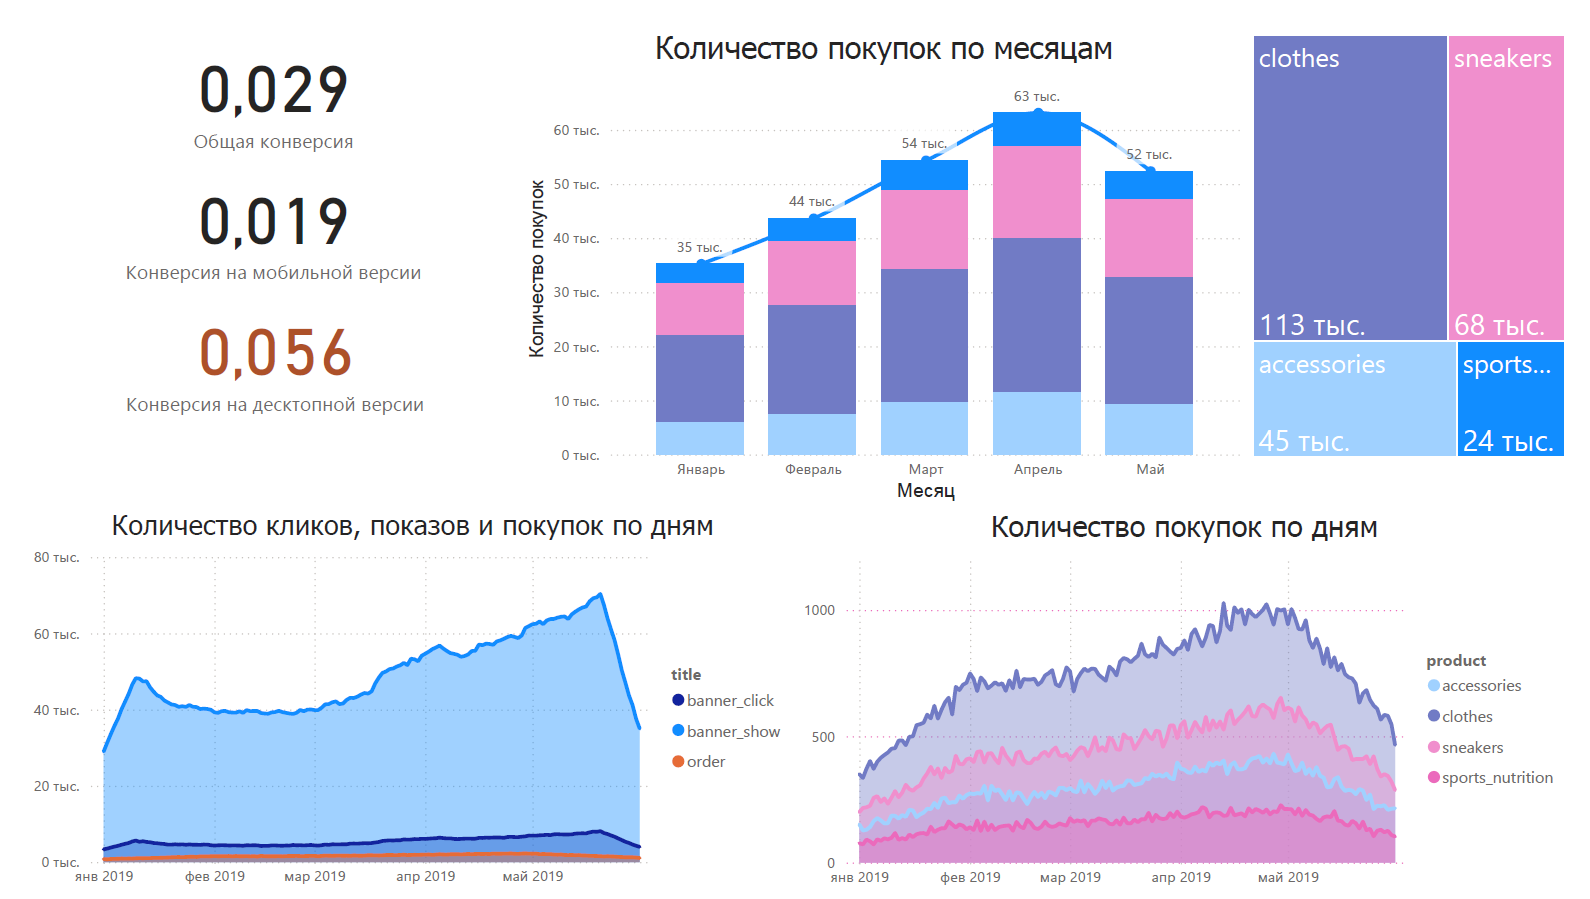

**Ключевые выводы:**
1. Мобильная версия сайта пользуется большей популярностью, но покупки совершаются преимущественно с декстопной версии.
2. Больше всего покупок совершается при показе рекламного баннера с одеждой. Наименьший отклик вызывает рекламный баннер с информацией о компании (company), не совершено ни одной покупки с таким типом баннера.
3. Максимальное количество продаж зафиксировано в апреле 2019 года.
4. Пик активности на сайте интернет-магазина приходится на апрель-май 2019 года.

## A/B тестирование

Согласно проведенному анализу можем выдвинуть следущие гипотезы:


**Нулевая гипотеза, H0:** в мобильной и десктопной версиях сайта конверсия (отношение покупок к показам) одинакова.

**Альтернативная гипотеза, H1:** конверсия в мобильной и десктопной версиях сайта значительно отличается.

Отберем нужные для A/B теста данные:

In [26]:
mobile_users = data[(data['site_version'] == 'mobile') & (data['title'].isin(['banner_show', 'order']))]['user_id'].unique()
desktop_users = data[(data['site_version'] == 'desktop') & (data['title'].isin(['banner_show', 'order']))]['user_id'].unique()

min_users = min(len(mobile_users), len(desktop_users))

np.random.seed(42)
sample_mobile_users = np.random.choice(mobile_users, min_users, replace=False)
sample_desktop_users = np.random.choice(desktop_users, min_users, replace=False)

mobile_sample = data[(data['site_version'] == 'mobile') & (data['user_id'].isin(sample_mobile_users))]
desktop_sample = data[(data['site_version'] == 'desktop') & (data['user_id'].isin(sample_desktop_users))]

sample_df = pd.concat([mobile_sample, desktop_sample])
print('Размер выборки: ', len(sample_df))

Размер выборки:  5416901


Подсчитаем количество показов и покупок для каждой версии сайта:

In [27]:
mobile_shows = sample_df[(sample_df['site_version'] == 'mobile') & (sample_df['title'] == 'banner_show')].shape[0]
mobile_purchases = sample_df[(sample_df['site_version'] == 'mobile') & (sample_df['title'] == 'order')].shape[0]
desktop_shows = sample_df[(sample_df['site_version'] == 'desktop') & (sample_df['title'] == 'banner_show')].shape[0]
desktop_purchases = sample_df[(sample_df['site_version'] == 'desktop') & (sample_df['title'] == 'order')].shape[0]

In [28]:
print(f"Показы мобильная: {mobile_shows}, Покупки мобильная: {mobile_purchases}")
print(f"Показы десктопная: {desktop_shows}, Покупки десктопная: {desktop_purchases}")

Показы мобильная: 2620549, Покупки мобильная: 57576
Показы десктопная: 2134639, Покупки десктопная: 133181


Для сравнения конверсий проведем Z-тест и проверим гипотезу о равенстве двух пропорций:

In [30]:
counts = [mobile_purchases, desktop_purchases]
nobs = [mobile_shows, desktop_shows]

stat, pval = proportions_ztest(counts, nobs)

print("p-value = {:.3f}".format(pval))

if pval < 0.05:
  print('Отвергаем нулевую гипотезу. Конверсии в мобильной и десктопной версиях сайта различаются.')
else:
  print('Мы не можем отвергнуть нулевую гипотезу. Конверсии в мобильной и десктопной версиях сайта не различаются.')

p-value = 0.000
Отвергаем нулевую гипотезу. Конверсии в мобильной и десктопной версиях сайта различаются.


Конверсии в мобильной и десктопной версиях сайта существенно отличаются. Пользователи мобильной версии сайта значительно реже совершают покупки по сравнению с пользователями десктопной версии.